<a href="https://colab.research.google.com/github/purbayankar/FeatureFusionUNet/blob/main/DeconvUNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Imports

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torchvision.transforms as tr

# Models
# from unet import Unet
# from siamunet_conc import SiamUnet_conc
# from siamunet_diff import SiamUnet_diff
# from fresunet import FresUNet

# Other
import os
import numpy as np
import random
from skimage import io
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm as tqdm
from pandas import read_csv
from math import floor, ceil, sqrt, exp
from IPython import display
import time
from itertools import chain
import time
import warnings
from pprint import pprint



print('IMPORTS OK')


IMPORTS OK


In [ ]:
# Global Variables' Definitions

PATH_TO_DATASET = '/content/drive/My Drive/OneraDataset_Images/'
IS_PROTOTYPE = False

FP_MODIFIER = 10 # Tuning parameter, use 1 if unsure

BATCH_SIZE = 32
PATCH_SIDE = 96
N_EPOCHS = 50

NORMALISE_IMGS = True

TRAIN_STRIDE = int(PATCH_SIDE/2) - 1

TYPE = 3 # 0-RGB | 1-RGBIr | 2-All bands s.t. resulution <= 20m | 3-All bands

LOAD_TRAINED = False

DATA_AUG = True


print('DEFINITIONS OK')

DEFINITIONS OK


In [ ]:
# Functions

def adjust_shape(I, s):
    """Adjust shape of grayscale image I to s."""
    
    # crop if necesary
    I = I[:s[0],:s[1]]
    si = I.shape
    
    # pad if necessary 
    p0 = max(0,s[0] - si[0])
    p1 = max(0,s[1] - si[1])
    
    return np.pad(I,((0,p0),(0,p1)),'edge')
    

def read_sentinel_img(path):
    """Read cropped Sentinel-2 image: RGB bands."""
    im_name = os.listdir(path)[0][:-7]
    r = io.imread(path + im_name + "B04.tif")
    g = io.imread(path + im_name + "B03.tif")
    b = io.imread(path + im_name + "B02.tif")
    
    I = np.stack((r,g,b),axis=2).astype('float')
    
    if NORMALISE_IMGS:
        I = (I - I.mean()) / I.std()

    return I

def read_sentinel_img_4(path):
    """Read cropped Sentinel-2 image: RGB and NIR bands."""
    im_name = os.listdir(path)[0][:-7]
    r = io.imread(path + im_name + "B04.tif")
    g = io.imread(path + im_name + "B03.tif")
    b = io.imread(path + im_name + "B02.tif")
    nir = io.imread(path + im_name + "B08.tif")
    
    I = np.stack((r,g,b,nir),axis=2).astype('float')
    
    if NORMALISE_IMGS:
        I = (I - I.mean()) / I.std()

    return I

def read_sentinel_img_leq20(path):
    """Read cropped Sentinel-2 image: bands with resolution less than or equals to 20m."""
    im_name = os.listdir(path)[0][:-7]
    
    r = io.imread(path + im_name + "B04.tif")
    s = r.shape
    g = io.imread(path + im_name + "B03.tif")
    b = io.imread(path + im_name + "B02.tif")
    nir = io.imread(path + im_name + "B08.tif")
    
    ir1 = adjust_shape(zoom(io.imread(path + im_name + "B05.tif"),2),s)
    ir2 = adjust_shape(zoom(io.imread(path + im_name + "B06.tif"),2),s)
    ir3 = adjust_shape(zoom(io.imread(path + im_name + "B07.tif"),2),s)
    nir2 = adjust_shape(zoom(io.imread(path + im_name + "B8A.tif"),2),s)
    swir2 = adjust_shape(zoom(io.imread(path + im_name + "B11.tif"),2),s)
    swir3 = adjust_shape(zoom(io.imread(path + im_name + "B12.tif"),2),s)
    
    I = np.stack((r,g,b,nir,ir1,ir2,ir3,nir2,swir2,swir3),axis=2).astype('float')
    
    if NORMALISE_IMGS:
        I = (I - I.mean()) / I.std()

    return I

def read_sentinel_img_leq60(path):
    """Read cropped Sentinel-2 image: all bands."""
    im_name = os.listdir(path)[0][:-7]
    
    r = io.imread(path + im_name + "B04.tif")
    s = r.shape
    g = io.imread(path + im_name + "B03.tif")
    b = io.imread(path + im_name + "B02.tif")
    nir = io.imread(path + im_name + "B08.tif")
    
    ir1 = adjust_shape(zoom(io.imread(path + im_name + "B05.tif"),2),s)
    ir2 = adjust_shape(zoom(io.imread(path + im_name + "B06.tif"),2),s)
    ir3 = adjust_shape(zoom(io.imread(path + im_name + "B07.tif"),2),s)
    nir2 = adjust_shape(zoom(io.imread(path + im_name + "B8A.tif"),2),s)
    swir2 = adjust_shape(zoom(io.imread(path + im_name + "B11.tif"),2),s)
    swir3 = adjust_shape(zoom(io.imread(path + im_name + "B12.tif"),2),s)
    
    uv = adjust_shape(zoom(io.imread(path + im_name + "B01.tif"),6),s)
    wv = adjust_shape(zoom(io.imread(path + im_name + "B09.tif"),6),s)
    swirc = adjust_shape(zoom(io.imread(path + im_name + "B10.tif"),6),s)
    
    I = np.stack((r,g,b,nir,ir1,ir2,ir3,nir2,swir2,swir3,uv,wv,swirc),axis=2).astype('float')
    
    if NORMALISE_IMGS:
        I = (I - I.mean()) / I.std()

    return I

def read_sentinel_img_trio(path):
    """Read cropped Sentinel-2 image pair and change map."""
#     read images
    if TYPE == 0:
        I1 = read_sentinel_img(path + '/imgs_1/')
        I2 = read_sentinel_img(path + '/imgs_2/')
    elif TYPE == 1:
        I1 = read_sentinel_img_4(path + '/imgs_1/')
        I2 = read_sentinel_img_4(path + '/imgs_2/')
    elif TYPE == 2:
        I1 = read_sentinel_img_leq20(path + '/imgs_1/')
        I2 = read_sentinel_img_leq20(path + '/imgs_2/')
    elif TYPE == 3:
        I1 = read_sentinel_img_leq60(path + '/imgs_1/')
        I2 = read_sentinel_img_leq60(path + '/imgs_2/')
        
    cm = io.imread(path + '/cm/cm.png', as_gray=True) != 0
    
    # crop if necessary
    s1 = I1.shape
    s2 = I2.shape
    I2 = np.pad(I2,((0, s1[0] - s2[0]), (0, s1[1] - s2[1]), (0,0)),'edge')
    
    
    return I1, I2, cm



def reshape_for_torch(I):
    """Transpose image for PyTorch coordinates."""
#     out = np.swapaxes(I,1,2)
#     out = np.swapaxes(out,0,1)
#     out = out[np.newaxis,:]
    out = I.transpose((2, 0, 1))
    return torch.from_numpy(out)



class ChangeDetectionDataset(Dataset):
    """Change Detection dataset class, used for both training and test data."""

    def __init__(self, path, train = True, patch_side = 96, stride = None, use_all_bands = False, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        
        # basics
        self.transform = transform
        self.path = path
        self.patch_side = patch_side
        if not stride:
            self.stride = 1
        else:
            self.stride = stride
        
        if train:
            fname = 'train.txt'
        else:
            fname = 'test.txt'
        
#         print(path + fname)
        self.names = read_csv(path + fname).columns
        self.n_imgs = self.names.shape[0]
        
        n_pix = 0
        true_pix = 0
        
        
        # load images
        self.imgs_1 = {}
        self.imgs_2 = {}
        self.change_maps = {}
        self.n_patches_per_image = {}
        self.n_patches = 0
        self.patch_coords = []
        for im_name in tqdm(self.names):
            # load and store each image
            I1, I2, cm = read_sentinel_img_trio(self.path + im_name)
            self.imgs_1[im_name] = reshape_for_torch(I1)
            self.imgs_2[im_name] = reshape_for_torch(I2)
            self.change_maps[im_name] = cm
            
            s = cm.shape
            n_pix += np.prod(s)
            true_pix += cm.sum()
            
            # calculate the number of patches
            s = self.imgs_1[im_name].shape
            n1 = ceil((s[1] - self.patch_side + 1) / self.stride)
            n2 = ceil((s[2] - self.patch_side + 1) / self.stride)
            n_patches_i = n1 * n2
            self.n_patches_per_image[im_name] = n_patches_i
            self.n_patches += n_patches_i
            
            # generate path coordinates
            for i in range(n1):
                for j in range(n2):
                    # coordinates in (x1, x2, y1, y2)
                    current_patch_coords = (im_name, 
                                    [self.stride*i, self.stride*i + self.patch_side, self.stride*j, self.stride*j + self.patch_side],
                                    [self.stride*(i + 1), self.stride*(j + 1)])
                    self.patch_coords.append(current_patch_coords)
                    
        self.weights = [ FP_MODIFIER * 2 * true_pix / n_pix, 2 * (n_pix - true_pix) / n_pix]
        
        

    def get_img(self, im_name):
        return self.imgs_1[im_name], self.imgs_2[im_name], self.change_maps[im_name]

    def __len__(self):
        return self.n_patches

    def __getitem__(self, idx):
        current_patch_coords = self.patch_coords[idx]
        im_name = current_patch_coords[0]
        limits = current_patch_coords[1]
        centre = current_patch_coords[2]
        
        I1 = self.imgs_1[im_name][:, limits[0]:limits[1], limits[2]:limits[3]]
        I2 = self.imgs_2[im_name][:, limits[0]:limits[1], limits[2]:limits[3]]
        
        label = self.change_maps[im_name][limits[0]:limits[1], limits[2]:limits[3]]
        label = torch.from_numpy(1*np.array(label)).float()
        
        sample = {'I1': I1, 'I2': I2, 'label': label}
        
        if self.transform:
            sample = self.transform(sample)

        return sample



class RandomFlip(object):
    """Flip randomly the images in a sample."""

#     def __init__(self):
#         return

    def __call__(self, sample):
        I1, I2, label = sample['I1'], sample['I2'], sample['label']
        
        if random.random() > 0.5:
            I1 =  I1.numpy()[:,:,::-1].copy()
            I1 = torch.from_numpy(I1)
            I2 =  I2.numpy()[:,:,::-1].copy()
            I2 = torch.from_numpy(I2)
            label =  label.numpy()[:,::-1].copy()
            label = torch.from_numpy(label)

        return {'I1': I1, 'I2': I2, 'label': label}



class RandomRot(object):
    """Rotate randomly the images in a sample."""

#     def __init__(self):
#         return

    def __call__(self, sample):
        I1, I2, label = sample['I1'], sample['I2'], sample['label']
        
        n = random.randint(0, 3)
        if n:
            I1 =  sample['I1'].numpy()
            I1 = np.rot90(I1, n, axes=(1, 2)).copy()
            I1 = torch.from_numpy(I1)
            I2 =  sample['I2'].numpy()
            I2 = np.rot90(I2, n, axes=(1, 2)).copy()
            I2 = torch.from_numpy(I2)
            label =  sample['label'].numpy()
            label = np.rot90(label, n, axes=(0, 1)).copy()
            label = torch.from_numpy(label)

        return {'I1': I1, 'I2': I2, 'label': label}





print('UTILS OK')


UTILS OK


In [ ]:
# Dataset


if DATA_AUG:
    data_transform = tr.Compose([RandomFlip(), RandomRot()])
else:
    data_transform = None


        

train_dataset = ChangeDetectionDataset(PATH_TO_DATASET, train = True, stride = TRAIN_STRIDE, transform=data_transform)
weights = torch.FloatTensor(train_dataset.weights).cuda()
print(weights)
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 4)

test_dataset = ChangeDetectionDataset(PATH_TO_DATASET, train = False, stride = TRAIN_STRIDE)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 4)


print('DATASETS OK')

100%|██████████| 14/14 [02:20<00:00, 10.01s/it]


tensor([0.4595, 1.9540], device='cuda:0')


100%|██████████| 10/10 [01:30<00:00,  9.01s/it]

DATASETS OK


In [ ]:
# print(weights)

**Deconvolution Network**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


from torch.nn.modules import conv
from torch.nn.modules.utils import _pair
import math

#iteratively solve for inverse sqrt of a matrix
def isqrt_newton_schulz_autograd(A, numIters):
    dim = A.shape[0]
    normA=A.norm()
    Y = A.div(normA)
    I = torch.eye(dim,dtype=A.dtype,device=A.device)
    Z = torch.eye(dim,dtype=A.dtype,device=A.device)

    for i in range(numIters):
        T = 0.5*(3.0*I - Z@Y)
        Y = Y@T
        Z = T@Z
    #A_sqrt = Y*torch.sqrt(normA)
    A_isqrt = Z / torch.sqrt(normA)
    return A_isqrt

def isqrt_newton_schulz_autograd_batch(A, numIters):
    batchSize,dim,_ = A.shape
    normA=A.view(batchSize, -1).norm(2, 1).view(batchSize, 1, 1)
    Y = A.div(normA)
    I = torch.eye(dim,dtype=A.dtype,device=A.device).unsqueeze(0).expand_as(A)
    Z = torch.eye(dim,dtype=A.dtype,device=A.device).unsqueeze(0).expand_as(A)

    for i in range(numIters):
        T = 0.5*(3.0*I - Z.bmm(Y))
        Y = Y.bmm(T)
        Z = T.bmm(Z)
    #A_sqrt = Y*torch.sqrt(normA)
    A_isqrt = Z / torch.sqrt(normA)

    return A_isqrt



#deconvolve channels
class ChannelDeconv(nn.Module):
    def __init__(self,  block, eps=1e-2,n_iter=5,momentum=0.1,sampling_stride=3):
        super(ChannelDeconv, self).__init__()

        self.eps = eps
        self.n_iter=n_iter
        self.momentum=momentum
        self.block = block

        self.register_buffer('running_mean1', torch.zeros(block, 1))
        #self.register_buffer('running_cov', torch.eye(block))
        self.register_buffer('running_deconv', torch.eye(block))
        self.register_buffer('running_mean2', torch.zeros(1, 1))
        self.register_buffer('running_var', torch.ones(1, 1))
        self.register_buffer('num_batches_tracked', torch.tensor(0, dtype=torch.long))
        self.sampling_stride=sampling_stride
    def forward(self, x):
        x_shape = x.shape
        if len(x.shape)==2:
            x=x.view(x.shape[0],x.shape[1],1,1)
        if len(x.shape)==3:
            print('Error! Unsupprted tensor shape.')

        N, C, H, W = x.size()
        B = self.block

        #take the first c channels out for deconv
        c=int(C/B)*B
        if c==0:
            print('Error! block should be set smaller.')

        #step 1. remove mean
        if c!=C:
            x1=x[:,:c].permute(1,0,2,3).contiguous().view(B,-1)
        else:
            x1=x.permute(1,0,2,3).contiguous().view(B,-1)

        if self.sampling_stride > 1 and H >= self.sampling_stride and W >= self.sampling_stride:
            x1_s = x1[:,::self.sampling_stride**2]
        else:
            x1_s=x1

        mean1 = x1_s.mean(-1, keepdim=True)

        if self.num_batches_tracked==0:
            self.running_mean1.copy_(mean1.detach())
        if self.training:
            self.running_mean1.mul_(1-self.momentum)
            self.running_mean1.add_(mean1.detach()*self.momentum)
        else:
            mean1 = self.running_mean1

        x1=x1-mean1

        #step 2. calculate deconv@x1 = cov^(-0.5)@x1
        if self.training:
            cov = x1_s @ x1_s.t() / x1_s.shape[1] + self.eps * torch.eye(B, dtype=x.dtype, device=x.device)
            deconv = isqrt_newton_schulz_autograd(cov, self.n_iter)

        if self.num_batches_tracked==0:
            #self.running_cov.copy_(cov.detach())
            self.running_deconv.copy_(deconv.detach())

        if self.training:
            #self.running_cov.mul_(1-self.momentum)
            #self.running_cov.add_(cov.detach()*self.momentum)
            self.running_deconv.mul_(1 - self.momentum)
            self.running_deconv.add_(deconv.detach() * self.momentum)
        else:
            # cov = self.running_cov
            deconv = self.running_deconv

        x1 =deconv@x1

        #reshape to N,c,J,W
        x1 = x1.view(c, N, H, W).contiguous().permute(1,0,2,3)

        # normalize the remaining channels
        if c!=C:
            x_tmp=x[:, c:].view(N,-1)
            if self.sampling_stride > 1 and H>=self.sampling_stride and W>=self.sampling_stride:
                x_s = x_tmp[:, ::self.sampling_stride ** 2]
            else:
                x_s = x_tmp

            mean2=x_s.mean()
            var=x_s.var()

            if self.num_batches_tracked == 0:
                self.running_mean2.copy_(mean2.detach())
                self.running_var.copy_(var.detach())

            if self.training:
                self.running_mean2.mul_(1 - self.momentum)
                self.running_mean2.add_(mean2.detach() * self.momentum)
                self.running_var.mul_(1 - self.momentum)
                self.running_var.add_(var.detach() * self.momentum)
            else:
                mean2 = self.running_mean2
                var = self.running_var

            x_tmp = (x[:, c:] - mean2) / (var + self.eps).sqrt()
            x1 = torch.cat([x1, x_tmp], dim=1)


        if self.training:
            self.num_batches_tracked.add_(1)

        if len(x_shape)==2:
            x1=x1.view(x_shape)
        return x1

#An alternative implementation
class Delinear(nn.Module):
    __constants__ = ['bias', 'in_features', 'out_features']

    def __init__(self, in_features, out_features, bias=True, eps=1e-5, n_iter=5, momentum=0.1, block=512):
        super(Delinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.Tensor(out_features, in_features))
        if bias:
            self.bias = nn.Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()



        if block > in_features:
            block = in_features
        else:
            if in_features%block!=0:
                block=math.gcd(block,in_features)
                print('block size set to:', block)
        self.block = block
        self.momentum = momentum
        self.n_iter = n_iter
        self.eps = eps
        self.register_buffer('running_mean', torch.zeros(self.block))
        self.register_buffer('running_deconv', torch.eye(self.block))


    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)

    def forward(self, input):

        if self.training:

            # 1. reshape
            X=input.view(-1, self.block)

            # 2. subtract mean
            X_mean = X.mean(0)
            X = X - X_mean.unsqueeze(0)
            self.running_mean.mul_(1 - self.momentum)
            self.running_mean.add_(X_mean.detach() * self.momentum)

            # 3. calculate COV, COV^(-0.5), then deconv
            # Cov = X.t() @ X / X.shape[0] + self.eps * torch.eye(X.shape[1], dtype=X.dtype, device=X.device)
            Id = torch.eye(X.shape[1], dtype=X.dtype, device=X.device)
            Cov = torch.addmm(self.eps, Id, 1. / X.shape[0], X.t(), X)
            deconv = isqrt_newton_schulz_autograd(Cov, self.n_iter)
            # track stats for evaluation
            self.running_deconv.mul_(1 - self.momentum)
            self.running_deconv.add_(deconv.detach() * self.momentum)

        else:
            X_mean = self.running_mean
            deconv = self.running_deconv

        w = self.weight.view(-1, self.block) @ deconv
        b = self.bias
        if self.bias is not None:
            b = b - (w @ (X_mean.unsqueeze(1))).view(self.weight.shape[0], -1).sum(1)
        w = w.view(self.weight.shape)
        return F.linear(input, w, b)

    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )



class FastDeconv(conv._ConvNd):

    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1,groups=1,bias=True, eps=1e-5, n_iter=5, momentum=0.1, block=64, sampling_stride=3,freeze=False,freeze_iter=100):
        self.momentum = momentum
        self.n_iter = n_iter
        self.eps = eps
        self.counter=0
        self.track_running_stats=True
        super(FastDeconv, self).__init__(
            in_channels, out_channels,  _pair(kernel_size), _pair(stride), _pair(padding), _pair(dilation),
            False, _pair(0), groups, bias, padding_mode='zeros')

        if block > in_channels:
            block = in_channels
        else:
            if in_channels%block!=0:
                block=math.gcd(block,in_channels)

        if groups>1:
            #grouped conv
            block=in_channels//groups

        self.block=block

        self.num_features = kernel_size**2 *block
        if groups==1:
            self.register_buffer('running_mean', torch.zeros(self.num_features))
            self.register_buffer('running_deconv', torch.eye(self.num_features))
        else:
            self.register_buffer('running_mean', torch.zeros(kernel_size ** 2 * in_channels))
            self.register_buffer('running_deconv', torch.eye(self.num_features).repeat(in_channels // block, 1, 1))

        self.sampling_stride=sampling_stride*stride
        self.counter=0
        self.freeze_iter=freeze_iter
        self.freeze=freeze

    def forward(self, x):
        N, C, H, W = x.shape
        B = self.block
        frozen=self.freeze and (self.counter>self.freeze_iter)
        if self.training and self.track_running_stats:
            self.counter+=1
            self.counter %= (self.freeze_iter * 10)

        if self.training and (not frozen):

            # 1. im2col: N x cols x pixels -> N*pixles x cols
            if self.kernel_size[0]>1:
                X = torch.nn.functional.unfold(x, self.kernel_size,self.dilation,self.padding,self.sampling_stride).transpose(1, 2).contiguous()
            else:
                #channel wise
                X = x.permute(0, 2, 3, 1).contiguous().view(-1, C)[::self.sampling_stride**2,:]

            if self.groups==1:
                # (C//B*N*pixels,k*k*B)
                X = X.view(-1, self.num_features, C // B).transpose(1, 2).contiguous().view(-1, self.num_features)
            else:
                X=X.view(-1,X.shape[-1])

            # 2. subtract mean
            X_mean = X.mean(0)
            X = X - X_mean.unsqueeze(0)

            # 3. calculate COV, COV^(-0.5), then deconv
            if self.groups==1:
                #Cov = X.t() @ X / X.shape[0] + self.eps * torch.eye(X.shape[1], dtype=X.dtype, device=X.device)
                Id=torch.eye(X.shape[1], dtype=X.dtype, device=X.device)
                Cov = torch.addmm(self.eps, Id, 1. / X.shape[0], X.t(), X)
                deconv = isqrt_newton_schulz_autograd(Cov, self.n_iter)
            else:
                X = X.view(-1, self.groups, self.num_features).transpose(0, 1)
                Id = torch.eye(self.num_features, dtype=X.dtype, device=X.device).expand(self.groups, self.num_features, self.num_features)
                Cov = torch.baddbmm(self.eps, Id, 1. / X.shape[1], X.transpose(1, 2), X)

                deconv = isqrt_newton_schulz_autograd_batch(Cov, self.n_iter)

            if self.track_running_stats:
                self.running_mean.mul_(1 - self.momentum)
                self.running_mean.add_(X_mean.detach() * self.momentum)
                # track stats for evaluation
                self.running_deconv.mul_(1 - self.momentum)
                self.running_deconv.add_(deconv.detach() * self.momentum)

        else:
            X_mean = self.running_mean
            deconv = self.running_deconv

        #4. X * deconv * conv = X * (deconv * conv)
        if self.groups==1:
            w = self.weight.view(-1, self.num_features, C // B).transpose(1, 2).contiguous().view(-1,self.num_features) @ deconv
            b = self.bias - (w @ (X_mean.unsqueeze(1))).view(self.weight.shape[0], -1).sum(1)
            w = w.view(-1, C // B, self.num_features).transpose(1, 2).contiguous()
        else:
            w = self.weight.view(C//B, -1,self.num_features)@deconv
            b = self.bias - (w @ (X_mean.view( -1,self.num_features,1))).view(self.bias.shape)

        w = w.view(self.weight.shape)
        x= F.conv2d(x, w, b, self.stride, self.padding, self.dilation, self.groups)

        return x

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.padding import ReplicationPad2d

class Unet(nn.Module):
    """EF segmentation network."""

    def __init__(self, input_nbr, label_nbr):
        super(Unet, self).__init__()

        self.input_nbr = input_nbr

        self.conv11 = FastDeconv(input_nbr, 16, kernel_size=3, padding=1)
        self.bn11 = nn.BatchNorm2d(16)
        self.do11 = nn.Dropout2d(p=0.2)
        self.conv12 = FastDeconv(16, 16, kernel_size=3, padding=1)
        self.bn12 = nn.BatchNorm2d(16)
        self.do12 = nn.Dropout2d(p=0.2)

        self.conv21 = FastDeconv(16, 32, kernel_size=3, padding=1)
        self.bn21 = nn.BatchNorm2d(32)
        self.do21 = nn.Dropout2d(p=0.2)
        self.conv22 = FastDeconv(32, 32, kernel_size=3, padding=1)
        self.bn22 = nn.BatchNorm2d(32)
        self.do22 = nn.Dropout2d(p=0.2)

        self.conv31 = FastDeconv(32, 64, kernel_size=3, padding=1)
        self.bn31 = nn.BatchNorm2d(64)
        self.do31 = nn.Dropout2d(p=0.2)
        self.conv32 = FastDeconv(64, 64, kernel_size=3, padding=1)
        self.bn32 = nn.BatchNorm2d(64)
        self.do32 = nn.Dropout2d(p=0.2)
        self.conv33 = FastDeconv(64, 64, kernel_size=3, padding=1)
        self.bn33 = nn.BatchNorm2d(64)
        self.do33 = nn.Dropout2d(p=0.2)

        self.conv41 = FastDeconv(64, 128, kernel_size=3, padding=1)
        self.bn41 = nn.BatchNorm2d(128)
        self.do41 = nn.Dropout2d(p=0.2)
        self.conv42 = FastDeconv(128, 128, kernel_size=3, padding=1)
        self.bn42 = nn.BatchNorm2d(128)
        self.do42 = nn.Dropout2d(p=0.2)
        self.conv43 = FastDeconv(128, 128, kernel_size=3, padding=1)
        self.bn43 = nn.BatchNorm2d(128)
        self.do43 = nn.Dropout2d(p=0.2)


        self.upconv4 = nn.ConvTranspose2d(128, 128, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv43d = nn.ConvTranspose2d(256, 128, kernel_size=3, padding=1)
        self.bn43d = nn.BatchNorm2d(128)
        self.do43d = nn.Dropout2d(p=0.2)
        self.conv42d = nn.ConvTranspose2d(128, 128, kernel_size=3, padding=1)
        self.bn42d = nn.BatchNorm2d(128)
        self.do42d = nn.Dropout2d(p=0.2)
        self.conv41d = nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1)
        self.bn41d = nn.BatchNorm2d(64)
        self.do41d = nn.Dropout2d(p=0.2)

        self.upconv3 = nn.ConvTranspose2d(64, 64, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv33d = nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1)
        self.bn33d = nn.BatchNorm2d(64)
        self.do33d = nn.Dropout2d(p=0.2)
        self.conv32d = nn.ConvTranspose2d(64, 64, kernel_size=3, padding=1)
        self.bn32d = nn.BatchNorm2d(64)
        self.do32d = nn.Dropout2d(p=0.2)
        self.conv31d = nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1)
        self.bn31d = nn.BatchNorm2d(32)
        self.do31d = nn.Dropout2d(p=0.2)

        self.upconv2 = nn.ConvTranspose2d(32, 32, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv22d = nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1)
        self.bn22d = nn.BatchNorm2d(32)
        self.do22d = nn.Dropout2d(p=0.2)
        self.conv21d = nn.ConvTranspose2d(32, 16, kernel_size=3, padding=1)
        self.bn21d = nn.BatchNorm2d(16)
        self.do21d = nn.Dropout2d(p=0.2)

        self.upconv1 = nn.ConvTranspose2d(16, 16, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv12d = nn.ConvTranspose2d(32, 16, kernel_size=3, padding=1)
        self.bn12d = nn.BatchNorm2d(16)
        self.do12d = nn.Dropout2d(p=0.2)
        self.conv11d = nn.ConvTranspose2d(16, label_nbr, kernel_size=3, padding=1)

        self.sm = nn.LogSoftmax(dim=1)

    def forward(self, x1, x2):

        x = torch.cat((x1, x2), 1)

        """Forward method."""
        # Stage 1
        x11 = self.do11(F.relu(self.bn11(self.conv11(x))))
        x12 = self.do12(F.relu(self.bn12(self.conv12(x11))))
        x1p = F.max_pool2d(x12, kernel_size=2, stride=2)

        # Stage 2
        x21 = self.do21(F.relu(self.bn21(self.conv21(x1p))))
        x22 = self.do22(F.relu(self.bn22(self.conv22(x21))))
        x2p = F.max_pool2d(x22, kernel_size=2, stride=2)

        # Stage 3
        x31 = self.do31(F.relu(self.bn31(self.conv31(x2p))))
        x32 = self.do32(F.relu(self.bn32(self.conv32(x31))))
        x33 = self.do33(F.relu(self.bn33(self.conv33(x32))))
        x3p = F.max_pool2d(x33, kernel_size=2, stride=2)

        # Stage 4
        x41 = self.do41(F.relu(self.bn41(self.conv41(x3p))))
        x42 = self.do42(F.relu(self.bn42(self.conv42(x41))))
        x43 = self.do43(F.relu(self.bn43(self.conv43(x42))))
        x4p = F.max_pool2d(x43, kernel_size=2, stride=2)


        # Stage 4d
        x4d = self.upconv4(x4p)
        pad4 = ReplicationPad2d((0, x43.size(3) - x4d.size(3), 0, x43.size(2) - x4d.size(2)))
        x4d = torch.cat((pad4(x4d), x43), 1)
        x43d = self.do43d(F.relu(self.bn43d(self.conv43d(x4d))))
        x42d = self.do42d(F.relu(self.bn42d(self.conv42d(x43d))))
        x41d = self.do41d(F.relu(self.bn41d(self.conv41d(x42d))))

        # Stage 3d
        x3d = self.upconv3(x41d)
        pad3 = ReplicationPad2d((0, x33.size(3) - x3d.size(3), 0, x33.size(2) - x3d.size(2)))
        x3d = torch.cat((pad3(x3d), x33), 1)
        x33d = self.do33d(F.relu(self.bn33d(self.conv33d(x3d))))
        x32d = self.do32d(F.relu(self.bn32d(self.conv32d(x33d))))
        x31d = self.do31d(F.relu(self.bn31d(self.conv31d(x32d))))

        # Stage 2d
        x2d = self.upconv2(x31d)
        pad2 = ReplicationPad2d((0, x22.size(3) - x2d.size(3), 0, x22.size(2) - x2d.size(2)))
        x2d = torch.cat((pad2(x2d), x22), 1)
        x22d = self.do22d(F.relu(self.bn22d(self.conv22d(x2d))))
        x21d = self.do21d(F.relu(self.bn21d(self.conv21d(x22d))))

        # Stage 1d
        x1d = self.upconv1(x21d)
        pad1 = ReplicationPad2d((0, x12.size(3) - x1d.size(3), 0, x12.size(2) - x1d.size(2)))
        x1d = torch.cat((pad1(x1d), x12), 1)
        x12d = self.do12d(F.relu(self.bn12d(self.conv12d(x1d))))
        x11d = self.conv11d(x12d)

        return self.sm(x11d)

In [ ]:
# 0-RGB | 1-RGBIr | 2-All bands s.t. resulution <= 20m | 3-All bands

if TYPE == 0:
    net, net_name = Unet(2*3, 2), 'FC-EF'
#     net, net_name = SiamUnet_conc(3, 2), 'FC-Siam-conc'
#     net, net_name = SiamUnet_diff(3, 2), 'FC-Siam-diff'
    # net, net_name = FresUNet(2*3, 2), 'FresUNet'
elif TYPE == 1:
    net, net_name = Unet(2*4, 2), 'FC-EF'
#     net, net_name = SiamUnet_conc(4, 2), 'FC-Siam-conc'
#     net, net_name = SiamUnet_diff(4, 2), 'FC-Siam-diff'
    # net, net_name = FresUNet(2*4, 2), 'FresUNet'
elif TYPE == 2:
    net, net_name = Unet(2*10, 2), 'FC-EF'
#     net, net_name = SiamUnet_conc(10, 2), 'FC-Siam-conc'
#     net, net_name = SiamUnet_diff(10, 2), 'FC-Siam-diff'
#     net, net_name = FresUNet(2*10, 2), 'FresUNet'
elif TYPE == 3:
    net, net_name = Unet(2*13, 2), 'FC-EF'
#     net, net_name = SiamUnet_conc(13, 2), 'FC-Siam-conc'
#     net, net_name = SiamUnet_diff(13, 2), 'FC-Siam-diff'
#     net, net_name = FresUNet(2*13, 2), 'FresUNet'


net.cuda()

criterion = nn.NLLLoss(weight=weights) # to be used with logsoftmax output
from torchsummary import summary

summary(net,input_size=[(13,256,256),(13,256,256)])

print('NETWORK OK')


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
        FastDeconv-1         [-1, 16, 256, 256]           3,760
       BatchNorm2d-2         [-1, 16, 256, 256]              32
         Dropout2d-3         [-1, 16, 256, 256]               0
        FastDeconv-4         [-1, 16, 256, 256]           2,320
       BatchNorm2d-5         [-1, 16, 256, 256]              32
         Dropout2d-6         [-1, 16, 256, 256]               0
        FastDeconv-7         [-1, 32, 128, 128]           4,640
       BatchNorm2d-8         [-1, 32, 128, 128]              64
         Dropout2d-9         [-1, 32, 128, 128]               0
       FastDeconv-10         [-1, 32, 128, 128]           9,248
      BatchNorm2d-11         [-1, 32, 128, 128]              64
        Dropout2d-12         [-1, 32, 128, 128]               0
       FastDeconv-13           [-1, 64, 64, 64]          18,496
      BatchNorm2d-14           [-1, 64,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:303: UserWarning: This overload of addmm is deprecated:
	addmm(Number beta, Tensor input, Number alpha, Tensor mat1, Tensor mat2, *, Tensor out)
Consider using one of the following signatures instead:
	addmm(Tensor input, Tensor mat1, Tensor mat2, *, Number beta, Number alpha, Tensor out) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)


In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print('Number of trainable parameters:', count_parameters(net))

Number of trainable parameters: 1353458


In [ ]:
# net.load_state_dict(torch.load('net-best_epoch-1_fm-0.7394933126157746.pth.tar'))

def train(n_epochs = N_EPOCHS, save = True):
    t = np.linspace(1, n_epochs, n_epochs)
    
    epoch_train_loss = 0 * t
    epoch_train_accuracy = 0 * t
    epoch_train_change_accuracy = 0 * t
    epoch_train_nochange_accuracy = 0 * t
    epoch_train_precision = 0 * t
    epoch_train_recall = 0 * t
    epoch_train_Fmeasure = 0 * t
    epoch_test_loss = 0 * t
    epoch_test_accuracy = 0 * t
    epoch_test_change_accuracy = 0 * t
    epoch_test_nochange_accuracy = 0 * t
    epoch_test_precision = 0 * t
    epoch_test_recall = 0 * t
    epoch_test_Fmeasure = 0 * t
    
#     mean_acc = 0
#     best_mean_acc = 0
    fm = 0
    best_fm = 0
    
    lss = 1000
    best_lss = 1000
    
    plt.figure(num=1)
    plt.figure(num=2)
    plt.figure(num=3)
    
    
    optimizer = torch.optim.Adam(net.parameters(), weight_decay=1e-4)
#     optimizer = torch.optim.Adam(net.parameters(), lr=0.0005)
        
    
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.95)
    
    
    for epoch_index in tqdm(range(n_epochs)):
        net.train()
        print('Epoch: ' + str(epoch_index + 1) + ' of ' + str(N_EPOCHS))

        tot_count = 0
        tot_loss = 0
        tot_accurate = 0
        class_correct = list(0. for i in range(2))
        class_total = list(0. for i in range(2))
#         for batch_index, batch in enumerate(tqdm(data_loader)):
        for batch in train_loader:
            I1 = Variable(batch['I1'].float().cuda())
            I2 = Variable(batch['I2'].float().cuda())
            label = torch.squeeze(Variable(batch['label'].cuda()))

            optimizer.zero_grad()
            output = net(I1, I2)
            loss = criterion(output, label.long())
            loss.backward()
            optimizer.step()
            
        scheduler.step()


        epoch_train_loss[epoch_index], epoch_train_accuracy[epoch_index], cl_acc, pr_rec = test(train_dataset)
        epoch_train_nochange_accuracy[epoch_index] = cl_acc[0]
        epoch_train_change_accuracy[epoch_index] = cl_acc[1]
        epoch_train_precision[epoch_index] = pr_rec[0]
        epoch_train_recall[epoch_index] = pr_rec[1]
        epoch_train_Fmeasure[epoch_index] = pr_rec[2]
        
#         epoch_test_loss[epoch_index], epoch_test_accuracy[epoch_index], cl_acc, pr_rec = test(test_dataset)
        epoch_test_loss[epoch_index], epoch_test_accuracy[epoch_index], cl_acc, pr_rec = test(test_dataset)
        epoch_test_nochange_accuracy[epoch_index] = cl_acc[0]
        epoch_test_change_accuracy[epoch_index] = cl_acc[1]
        epoch_test_precision[epoch_index] = pr_rec[0]
        epoch_test_recall[epoch_index] = pr_rec[1]
        epoch_test_Fmeasure[epoch_index] = pr_rec[2]

        plt.figure(num=1)
        plt.clf()
        l1_1, = plt.plot(t[:epoch_index + 1], epoch_train_loss[:epoch_index + 1], label='Train loss')
        l1_2, = plt.plot(t[:epoch_index + 1], epoch_test_loss[:epoch_index + 1], label='Test loss')
        plt.legend(handles=[l1_1, l1_2])
        plt.grid()
#         plt.gcf().gca().set_ylim(bottom = 0)
        plt.gcf().gca().set_xlim(left = 0)
        plt.title('Loss')
        display.clear_output(wait=True)
        display.display(plt.gcf())

        plt.figure(num=2)
        plt.clf()
        l2_1, = plt.plot(t[:epoch_index + 1], epoch_train_accuracy[:epoch_index + 1], label='Train accuracy')
        l2_2, = plt.plot(t[:epoch_index + 1], epoch_test_accuracy[:epoch_index + 1], label='Test accuracy')
        plt.legend(handles=[l2_1, l2_2])
        plt.grid()
        plt.gcf().gca().set_ylim(0, 100)
#         plt.gcf().gca().set_ylim(bottom = 0)
#         plt.gcf().gca().set_xlim(left = 0)
        plt.title('Accuracy')
        display.clear_output(wait=True)
        display.display(plt.gcf())

        plt.figure(num=3)
        plt.clf()
        l3_1, = plt.plot(t[:epoch_index + 1], epoch_train_nochange_accuracy[:epoch_index + 1], label='Train accuracy: no change')
        l3_2, = plt.plot(t[:epoch_index + 1], epoch_train_change_accuracy[:epoch_index + 1], label='Train accuracy: change')
        l3_3, = plt.plot(t[:epoch_index + 1], epoch_test_nochange_accuracy[:epoch_index + 1], label='Test accuracy: no change')
        l3_4, = plt.plot(t[:epoch_index + 1], epoch_test_change_accuracy[:epoch_index + 1], label='Test accuracy: change')
        plt.legend(handles=[l3_1, l3_2, l3_3, l3_4])
        plt.grid()
        plt.gcf().gca().set_ylim(0, 100)
#         plt.gcf().gca().set_ylim(bottom = 0)
#         plt.gcf().gca().set_xlim(left = 0)
        plt.title('Accuracy per class')
        display.clear_output(wait=True)
        display.display(plt.gcf())

        plt.figure(num=4)
        plt.clf()
        l4_1, = plt.plot(t[:epoch_index + 1], epoch_train_precision[:epoch_index + 1], label='Train precision')
        l4_2, = plt.plot(t[:epoch_index + 1], epoch_train_recall[:epoch_index + 1], label='Train recall')
        l4_3, = plt.plot(t[:epoch_index + 1], epoch_train_Fmeasure[:epoch_index + 1], label='Train Dice/F1')
        l4_4, = plt.plot(t[:epoch_index + 1], epoch_test_precision[:epoch_index + 1], label='Test precision')
        l4_5, = plt.plot(t[:epoch_index + 1], epoch_test_recall[:epoch_index + 1], label='Test recall')
        l4_6, = plt.plot(t[:epoch_index + 1], epoch_test_Fmeasure[:epoch_index + 1], label='Test Dice/F1')
        plt.legend(handles=[l4_1, l4_2, l4_3, l4_4, l4_5, l4_6])
        plt.grid()
        plt.gcf().gca().set_ylim(0, 1)
#         plt.gcf().gca().set_ylim(bottom = 0)
#         plt.gcf().gca().set_xlim(left = 0)
        plt.title('Precision, Recall and F-measure')
        display.clear_output(wait=True)
        display.display(plt.gcf())
        
        
#         mean_acc = (epoch_test_nochange_accuracy[epoch_index] + epoch_test_change_accuracy[epoch_index])/2
#         if mean_acc > best_mean_acc:
#             best_mean_acc = mean_acc
#             save_str = 'net-best_epoch-' + str(epoch_index + 1) + '_acc-' + str(mean_acc) + '.pth.tar'
#             torch.save(net.state_dict(), save_str)
        
        
#         fm = pr_rec[2]
        fm = epoch_train_Fmeasure[epoch_index]
        if fm > best_fm:
            best_fm = fm
            save_str = 'net-best_epoch-' + str(epoch_index + 1) + '_fm-' + str(fm) + '.pth.tar'
            torch.save(net.state_dict(), save_str)
        
        lss = epoch_train_loss[epoch_index]
        if lss < best_lss:
            best_lss = lss
            save_str = 'net-best_epoch-' + str(epoch_index + 1) + '_loss-' + str(lss) + '.pth.tar'
            torch.save(net.state_dict(), save_str)
            
            
#         print('Epoch loss: ' + str(tot_loss/tot_count))
        if save:
            im_format = 'png'
    #         im_format = 'eps'

            plt.figure(num=1)
            plt.savefig(net_name + '-01-loss.' + im_format)

            plt.figure(num=2)
            plt.savefig(net_name + '-02-accuracy.' + im_format)

            plt.figure(num=3)
            plt.savefig(net_name + '-03-accuracy-per-class.' + im_format)

            plt.figure(num=4)
            plt.savefig(net_name + '-04-prec-rec-fmeas.' + im_format)
        
    out = {'train_loss': epoch_train_loss[-1],
           'train_accuracy': epoch_train_accuracy[-1],
           'train_nochange_accuracy': epoch_train_nochange_accuracy[-1],
           'train_change_accuracy': epoch_train_change_accuracy[-1],
           'test_loss': epoch_test_loss[-1],
           'test_accuracy': epoch_test_accuracy[-1],
           'test_nochange_accuracy': epoch_test_nochange_accuracy[-1],
           'test_change_accuracy': epoch_test_change_accuracy[-1]}
    
    print('pr_c, rec_c, f_meas, pr_nc, rec_nc')
    print(pr_rec)
    
    return out

L = 1024
N = 2

def test(dset):
    net.eval()
    tot_loss = 0
    tot_count = 0
    tot_accurate = 0
    
    n = 2
    class_correct = list(0. for i in range(n))
    class_total = list(0. for i in range(n))
    class_accuracy = list(0. for i in range(n))
    
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    
    for img_index in dset.names:
        I1_full, I2_full, cm_full = dset.get_img(img_index)
        
        s = cm_full.shape
        

        steps0 = np.arange(0,s[0],ceil(s[0]/N))
        steps1 = np.arange(0,s[1],ceil(s[1]/N))
        for ii in range(N):
            for jj in range(N):
                xmin = steps0[ii]
                if ii == N-1:
                    xmax = s[0]
                else:
                    xmax = steps0[ii+1]
                ymin = jj
                if jj == N-1:
                    ymax = s[1]
                else:
                    ymax = steps1[jj+1]
                I1 = I1_full[:, xmin:xmax, ymin:ymax]
                I2 = I2_full[:, xmin:xmax, ymin:ymax]
                cm = cm_full[xmin:xmax, ymin:ymax]

                I1 = Variable(torch.unsqueeze(I1, 0).float()).cuda()
                I2 = Variable(torch.unsqueeze(I2, 0).float()).cuda()
                cm = Variable(torch.unsqueeze(torch.from_numpy(1.0*cm),0).float()).cuda()


                output = net(I1, I2)
                loss = criterion(output, cm.long())
        #         print(loss)
                tot_loss += loss.data * np.prod(cm.size())
                tot_count += np.prod(cm.size())

                _, predicted = torch.max(output.data, 1)

                c = (predicted.int() == cm.data.int())
                for i in range(c.size(1)):
                    for j in range(c.size(2)):
                        l = int(cm.data[0, i, j])
                        class_correct[l] += c[0, i, j]
                        class_total[l] += 1
                        
                pr = (predicted.int() > 0).cpu().numpy()
                gt = (cm.data.int() > 0).cpu().numpy()
                
                tp += np.logical_and(pr, gt).sum()
                tn += np.logical_and(np.logical_not(pr), np.logical_not(gt)).sum()
                fp += np.logical_and(pr, np.logical_not(gt)).sum()
                fn += np.logical_and(np.logical_not(pr), gt).sum()
        
    net_loss = tot_loss/tot_count
    net_accuracy = 100 * (tp + tn)/tot_count
    
    for i in range(n):
        class_accuracy[i] = 100 * class_correct[i] / max(class_total[i],0.00001)

    prec = tp / (tp + fp)
    rec = tp / (tp + fn)
    f_meas = 2 * prec * rec / (prec + rec)
    prec_nc = tn / (tn + fn)
    rec_nc = tn / (tn + fp)
    
    pr_rec = [prec, rec, f_meas, prec_nc, rec_nc]
        
    return net_loss, net_accuracy, class_accuracy, pr_rec
    
    



    


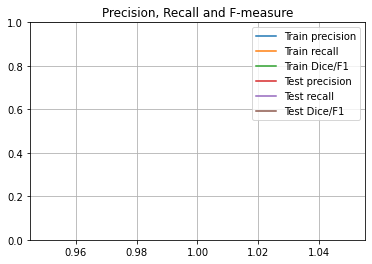

  2%|▏         | 1/50 [10:13<8:20:56, 613.40s/it]

Epoch: 2 of 50


KeyboardInterrupt: ignored

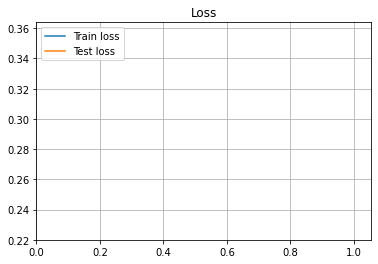

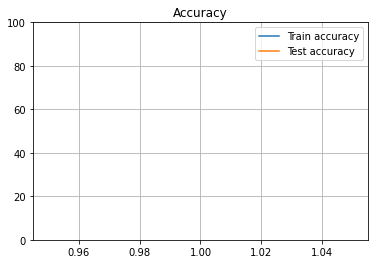

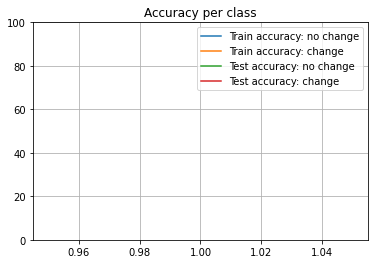

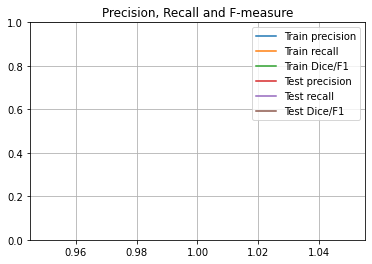

In [ ]:
if LOAD_TRAINED:
    net.load_state_dict(torch.load('net_final.pth.tar'))
    print('LOAD OK')
else:
    t_start = time.time()
    out_dic = train()
    t_end = time.time()
    print(out_dic)
    print('Elapsed time:')
    print(t_end - t_start)




In [ ]:
if not LOAD_TRAINED:
    torch.save(net.state_dict(), 'net_final.pth.tar')
    print('SAVE OK')

In [ ]:


def save_test_results(dset):
    for name in tqdm(dset.names):
        with warnings.catch_warnings():
            I1, I2, cm = dset.get_img(name)
            I1 = Variable(torch.unsqueeze(I1, 0).float()).cuda()
            I2 = Variable(torch.unsqueeze(I2, 0).float()).cuda()
            out = net(I1, I2)
            _, predicted = torch.max(out.data, 1)
            I = np.stack((255*cm,255*np.squeeze(predicted.cpu().numpy()),255*cm),2)
            io.imsave(f'{net_name}-{name}.png',I)



t_start = time.time()
# save_test_results(train_dataset)
save_test_results(test_dataset)
t_end = time.time()
print('Elapsed time: {}'.format(t_end - t_start))


In [ ]:
L = 1024

def kappa(tp, tn, fp, fn):
    N = tp + tn + fp + fn
    p0 = (tp + tn) / N
    pe = ((tp+fp)*(tp+fn) + (tn+fp)*(tn+fn)) / (N * N)
    
    return (p0 - pe) / (1 - pe)

def test(dset):
    net.eval()
    tot_loss = 0
    tot_count = 0
    tot_accurate = 0
    
    n = 2
    class_correct = list(0. for i in range(n))
    class_total = list(0. for i in range(n))
    class_accuracy = list(0. for i in range(n))
    
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    
    for img_index in tqdm(dset.names):
        I1_full, I2_full, cm_full = dset.get_img(img_index)
        
        s = cm_full.shape
        
        for ii in range(ceil(s[0]/L)):
            for jj in range(ceil(s[1]/L)):
                xmin = L*ii
                xmax = min(L*(ii+1),s[1])
                ymin = L*jj
                ymax = min(L*(jj+1),s[1])
                I1 = I1_full[:, xmin:xmax, ymin:ymax]
                I2 = I2_full[:, xmin:xmax, ymin:ymax]
                cm = cm_full[xmin:xmax, ymin:ymax]

                I1 = Variable(torch.unsqueeze(I1, 0).float()).cuda()
                I2 = Variable(torch.unsqueeze(I2, 0).float()).cuda()
                cm = Variable(torch.unsqueeze(torch.from_numpy(1.0*cm),0).float()).cuda()

                output = net(I1, I2)
                    
                loss = criterion(output, cm.long())
                tot_loss += loss.data * np.prod(cm.size())
                tot_count += np.prod(cm.size())

                _, predicted = torch.max(output.data, 1)

                c = (predicted.int() == cm.data.int())
                for i in range(c.size(1)):
                    for j in range(c.size(2)):
                        l = int(cm.data[0, i, j])
                        class_correct[l] += c[0, i, j]
                        class_total[l] += 1
                        
                pr = (predicted.int() > 0).cpu().numpy()
                gt = (cm.data.int() > 0).cpu().numpy()
                
                tp += np.logical_and(pr, gt).sum()
                tn += np.logical_and(np.logical_not(pr), np.logical_not(gt)).sum()
                fp += np.logical_and(pr, np.logical_not(gt)).sum()
                fn += np.logical_and(np.logical_not(pr), gt).sum()
        
    net_loss = tot_loss/tot_count        
    net_loss = float(net_loss.cpu().numpy())
    
    net_accuracy = 100 * (tp + tn)/tot_count
    
    for i in range(n):
        class_accuracy[i] = 100 * class_correct[i] / max(class_total[i],0.00001)
        class_accuracy[i] =  float(class_accuracy[i].cpu().numpy())

    prec = tp / (tp + fp)
    rec = tp / (tp + fn)
    dice = 2 * prec * rec / (prec + rec)
    prec_nc = tn / (tn + fn)
    rec_nc = tn / (tn + fp)
    
    pr_rec = [prec, rec, dice, prec_nc, rec_nc]
    
    k = kappa(tp, tn, fp, fn)
    
    return {'net_loss': net_loss, 
            'net_accuracy': net_accuracy, 
            'class_accuracy': class_accuracy, 
            'precision': prec, 
            'recall': rec, 
            'dice': dice, 
            'kappa': k}

results = test(test_dataset)
pprint(results)